In [73]:
import tensorflow.keras.datasets.mnist as mnist
from tensorflow.keras.datasets.mnist import load_data
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [74]:
dataset = load_data()

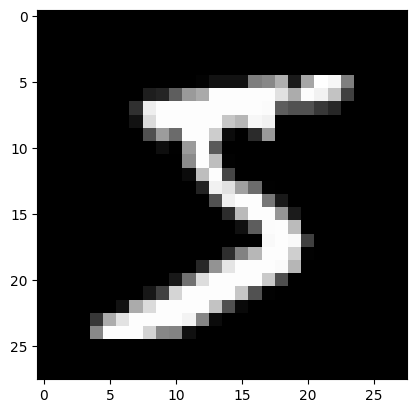

In [75]:
plt.imshow(dataset[0][0][0], cmap='gray')

In [76]:
# normalize the dataset
train_data, train_labels = dataset[0]
test_data, test_labels = dataset[1]

train_data = train_data.reshape(-1, 28, 28, 1).astype('float32')
test_data = test_data.reshape(-1, 28, 28, 1).astype('float32')
train_data = train_data / 255
test_data = test_data / 255

In [112]:
# add noise to the dataset
noise_factor = 0.35
train_data_noisy = train_data + noise_factor * tf.random.normal(shape=train_data.shape)
test_data_noisy = test_data + noise_factor * tf.random.normal(shape=test_data.shape)

In [113]:
# clip the values to be between 0 and 1
train_data_noisy = tf.clip_by_value(train_data_noisy, clip_value_min=0, clip_value_max=1)
test_data_noisy = tf.clip_by_value(test_data_noisy, clip_value_min=0, clip_value_max=1)

In [79]:
class CAE(tf.keras.Model):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(8, (3, 3), activation='relu', strides=2, padding='same'),
            tf.keras.layers.Conv2D(4, (3, 3), activation='relu', strides=2, padding='same')
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(4, (3, 3), activation='relu', strides=2, padding='same'),
            tf.keras.layers.Conv2DTranspose(8, (3, 3), activation='relu', strides=2, padding='same'),
            tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])
        
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [114]:
model = CAE()
model.compile(optimizer='adam', loss='mse')

In [115]:
model.fit(
    x=train_data,
    y=train_data,
    epochs=10,
    batch_size=64,
    validation_data=(test_data, test_data)
)
    

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0893 - val_loss: 0.0059
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0021 - val_loss: 0.0020


In [138]:
# Compute the reconstruction loss for the training data and a threshold (that will be the mean of the reconstruction errors + their standard deviation).
reconstructed = model.predict(train_data)
reconstruction_error = np.mean(np.square(train_data - reconstructed), axis=(1, 2, 3))
threshold = np.mean(reconstruction_error) + np.std(reconstruction_error)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [139]:
reconstruction_error, threshold

(array([0.00400878, 0.00390018, 0.00464629, ..., 0.00427845, 0.00860943,
        0.00782348], dtype=float32),
 np.float32(0.005910782))

In [140]:
test_reconstructed = model.predict(test_data)
test_errors = np.mean(np.square(test_data - test_reconstructed), axis=(1, 2, 3))

test_noisy_reconstructed = model.predict(test_data_noisy)
test_noisy_errors = np.mean(np.square(test_data_noisy - test_noisy_reconstructed), axis=(1, 2, 3))

test_preds = test_errors < threshold
test_noisy_preds = test_noisy_errors < threshold

test_accuracy = np.mean(test_preds)
test_noisy_accuracy = np.mean(test_noisy_preds)

print(f'Test accuracy: {test_accuracy}')
print(f'Test noisy accuracy: {test_noisy_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test accuracy: 0.889
Test noisy accuracy: 0.0


In [131]:
test_data_noisy = test_data_noisy.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


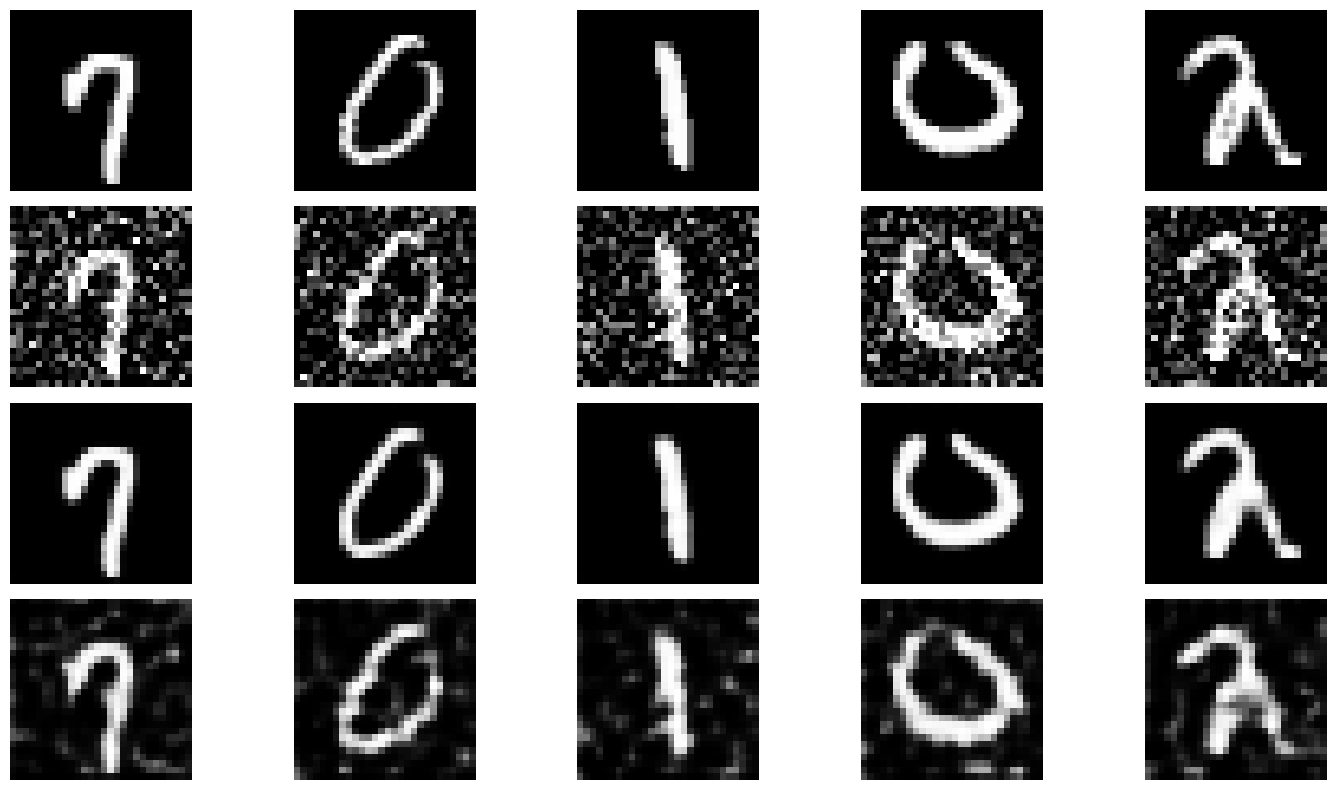

In [133]:
num_images = 5
indices = np.random.choice(len(test_data), num_images, replace=False)
sample_original = test_data[indices]
sample_noisy = test_data_noisy[indices]

reconstructed_from_original = model.predict(sample_original)
reconstructed_from_noisy = model.predict(sample_noisy)

fig, axes = plt.subplots(4, num_images, figsize=(15, 8))

for i in range(num_images):
    axes[0, i].imshow(sample_original[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(sample_noisy[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    
    axes[2, i].imshow(reconstructed_from_original[i].squeeze(), cmap='gray')
    axes[2, i].axis('off')
    
    axes[3, i].imshow(reconstructed_from_noisy[i].squeeze(), cmap='gray')
    axes[3, i].axis('off')

axes[0,0].set_ylabel("Original", fontsize=14)
axes[1,0].set_ylabel("Noisy Input", fontsize=14)
axes[2,0].set_ylabel("Recon from Original", fontsize=14)
axes[3,0].set_ylabel("Recon from Noisy", fontsize=14)

plt.tight_layout()
plt.show()

In [134]:
model = CAE()
model.compile(optimizer='adam', loss='mse')
model.fit(
    x=train_data_noisy,
    y=train_data,
    epochs=10,
    batch_size=64,
    validation_data=(test_data_noisy, test_data)
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.1013 - val_loss: 0.0117
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0094 - val_loss: 0.0091
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0092 - val_loss: 0.0089


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


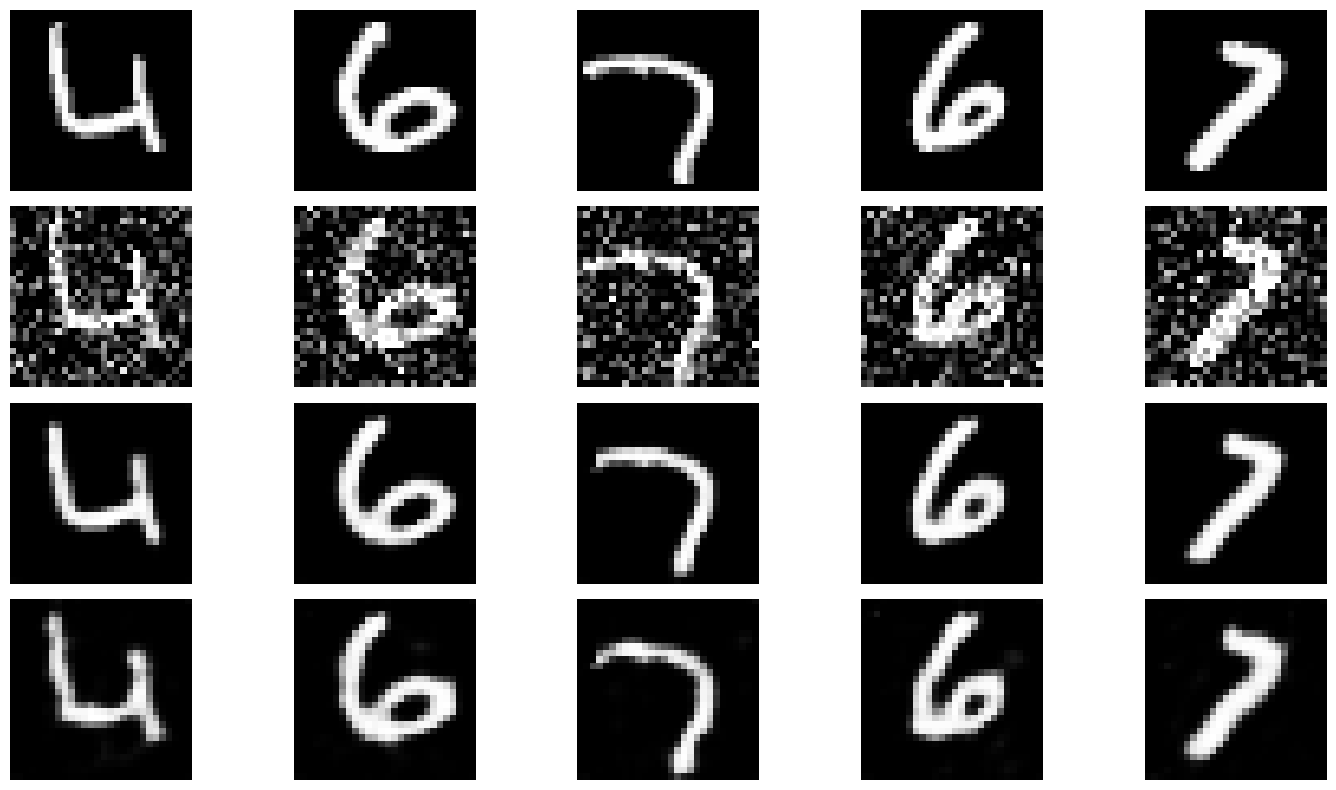

In [135]:
num_images = 5
indices = np.random.choice(len(test_data), num_images, replace=False)
sample_original = test_data[indices]
sample_noisy = test_data_noisy[indices]

reconstructed_from_original = model.predict(sample_original)
reconstructed_from_noisy = model.predict(sample_noisy)

fig, axes = plt.subplots(4, num_images, figsize=(15, 8))

for i in range(num_images):
    axes[0, i].imshow(sample_original[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(sample_noisy[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    
    axes[2, i].imshow(reconstructed_from_original[i].squeeze(), cmap='gray')
    axes[2, i].axis('off')
    
    axes[3, i].imshow(reconstructed_from_noisy[i].squeeze(), cmap='gray')
    axes[3, i].axis('off')

axes[0,0].set_ylabel("Original", fontsize=14)
axes[1,0].set_ylabel("Noisy Input", fontsize=14)
axes[2,0].set_ylabel("Recon from Original", fontsize=14)
axes[3,0].set_ylabel("Recon from Noisy", fontsize=14)

plt.tight_layout()
plt.show()